In [28]:
import torch
import os, json, math
from pathlib import Path
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Hessians stats

In [36]:
BASE_DIRS = ["./setup1" ] 
LR_TO_USE = "0.01"  # "0.01" или "0.1"
W_array = []
for BASE_DIR in BASE_DIRS:
    for alg in ['sgd', 'gd']:
        PATH = os.path.join(BASE_DIR, f"{alg}_weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]

        W = torch.load(PATH, map_location="cpu")
        W = W.detach().float()
        # N, T, D = W.shape
        print(W.shape)
        W_array.append(W)

W_SGD = W_array[0]
W_GD = W_array[1]


torch.Size([100, 11, 386])
torch.Size([11, 386])


In [37]:
W_SGD[0]

tensor([[ 0.0514, -0.0010,  0.1234,  ...,  0.5487, -0.7981,  0.4574],
        [ 0.0514, -0.0010,  0.1234,  ...,  0.5489, -0.7982,  0.4573],
        [ 0.0514, -0.0010,  0.1234,  ...,  0.5488, -0.7984,  0.4573],
        ...,
        [ 0.0514, -0.0010,  0.1233,  ...,  0.5478, -0.7996,  0.4576],
        [ 0.0514, -0.0010,  0.1233,  ...,  0.5483, -0.7994,  0.4574],
        [ 0.0514, -0.0009,  0.1233,  ...,  0.5483, -0.7994,  0.4573]])

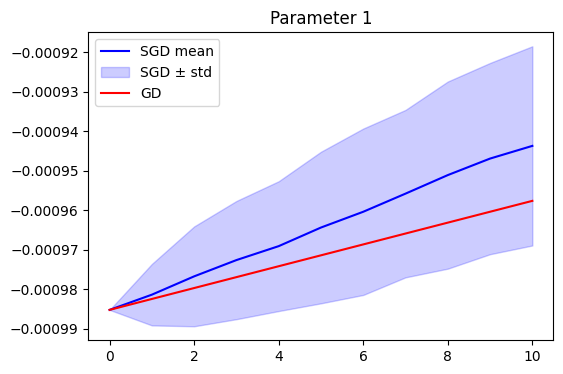

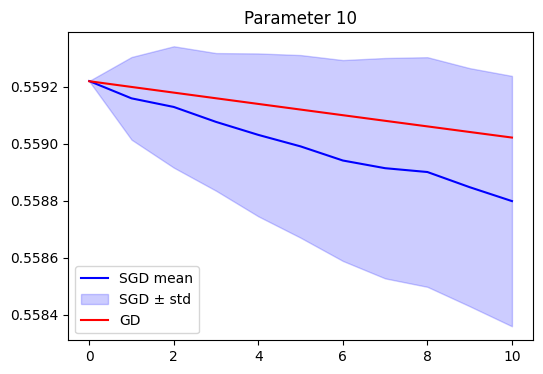

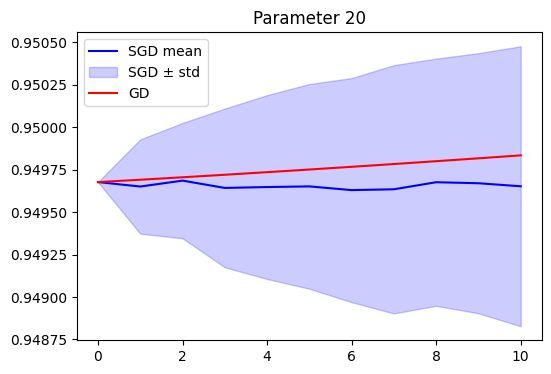

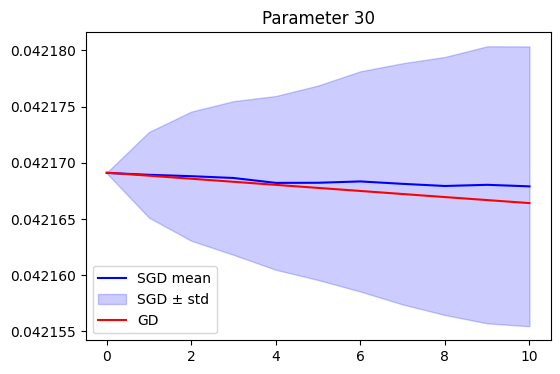

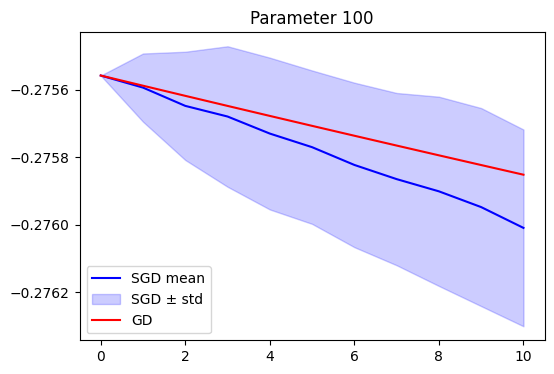

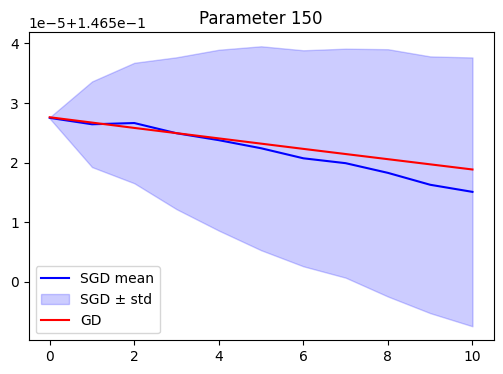

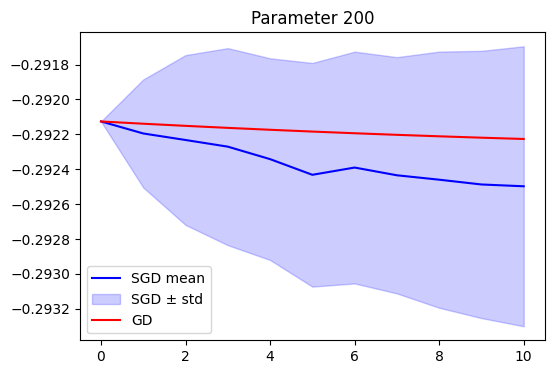

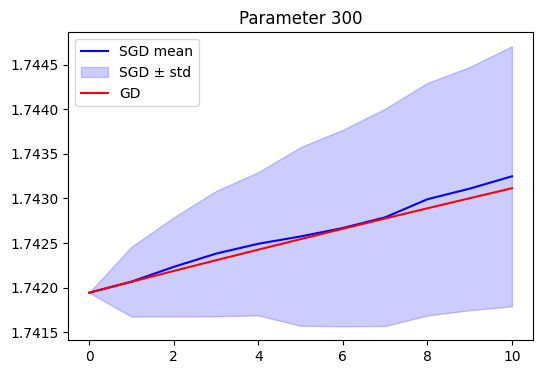

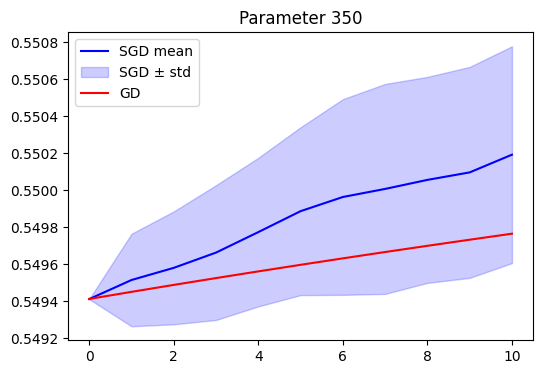

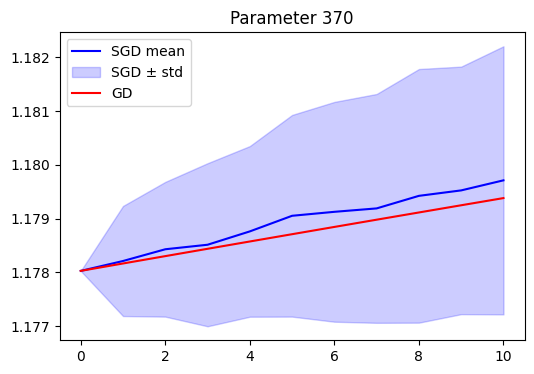

In [38]:
import numpy as np
import matplotlib.pyplot as plt

num_p_arr = [1, 10, 20, 30, 100, 150, 200, 300, 350, 370]

for num_p in num_p_arr:
    p_trajectories_sgd = W_SGD[:, :, num_p].numpy()  # shape: [n_trials, T]
    p_trajectories_gd = W_GD[:, num_p].numpy()    # shape: [1, T]

    # считаем среднее и std по траекториям SGD
    mean_sgd = np.mean(p_trajectories_sgd, axis=0)
    std_sgd = np.std(p_trajectories_sgd, axis=0)

    # график
    plt.figure(figsize=(6, 4))
    plt.plot(mean_sgd, label="SGD mean", color="blue")
    plt.fill_between(
        np.arange(len(mean_sgd)),
        mean_sgd - std_sgd,
        mean_sgd + std_sgd,
        color="blue",
        alpha=0.2,
        label="SGD ± std"
    )
    plt.plot(p_trajectories_gd, label="GD", color="red")
    plt.title(f"Parameter {num_p}")
    plt.legend()
    plt.show()


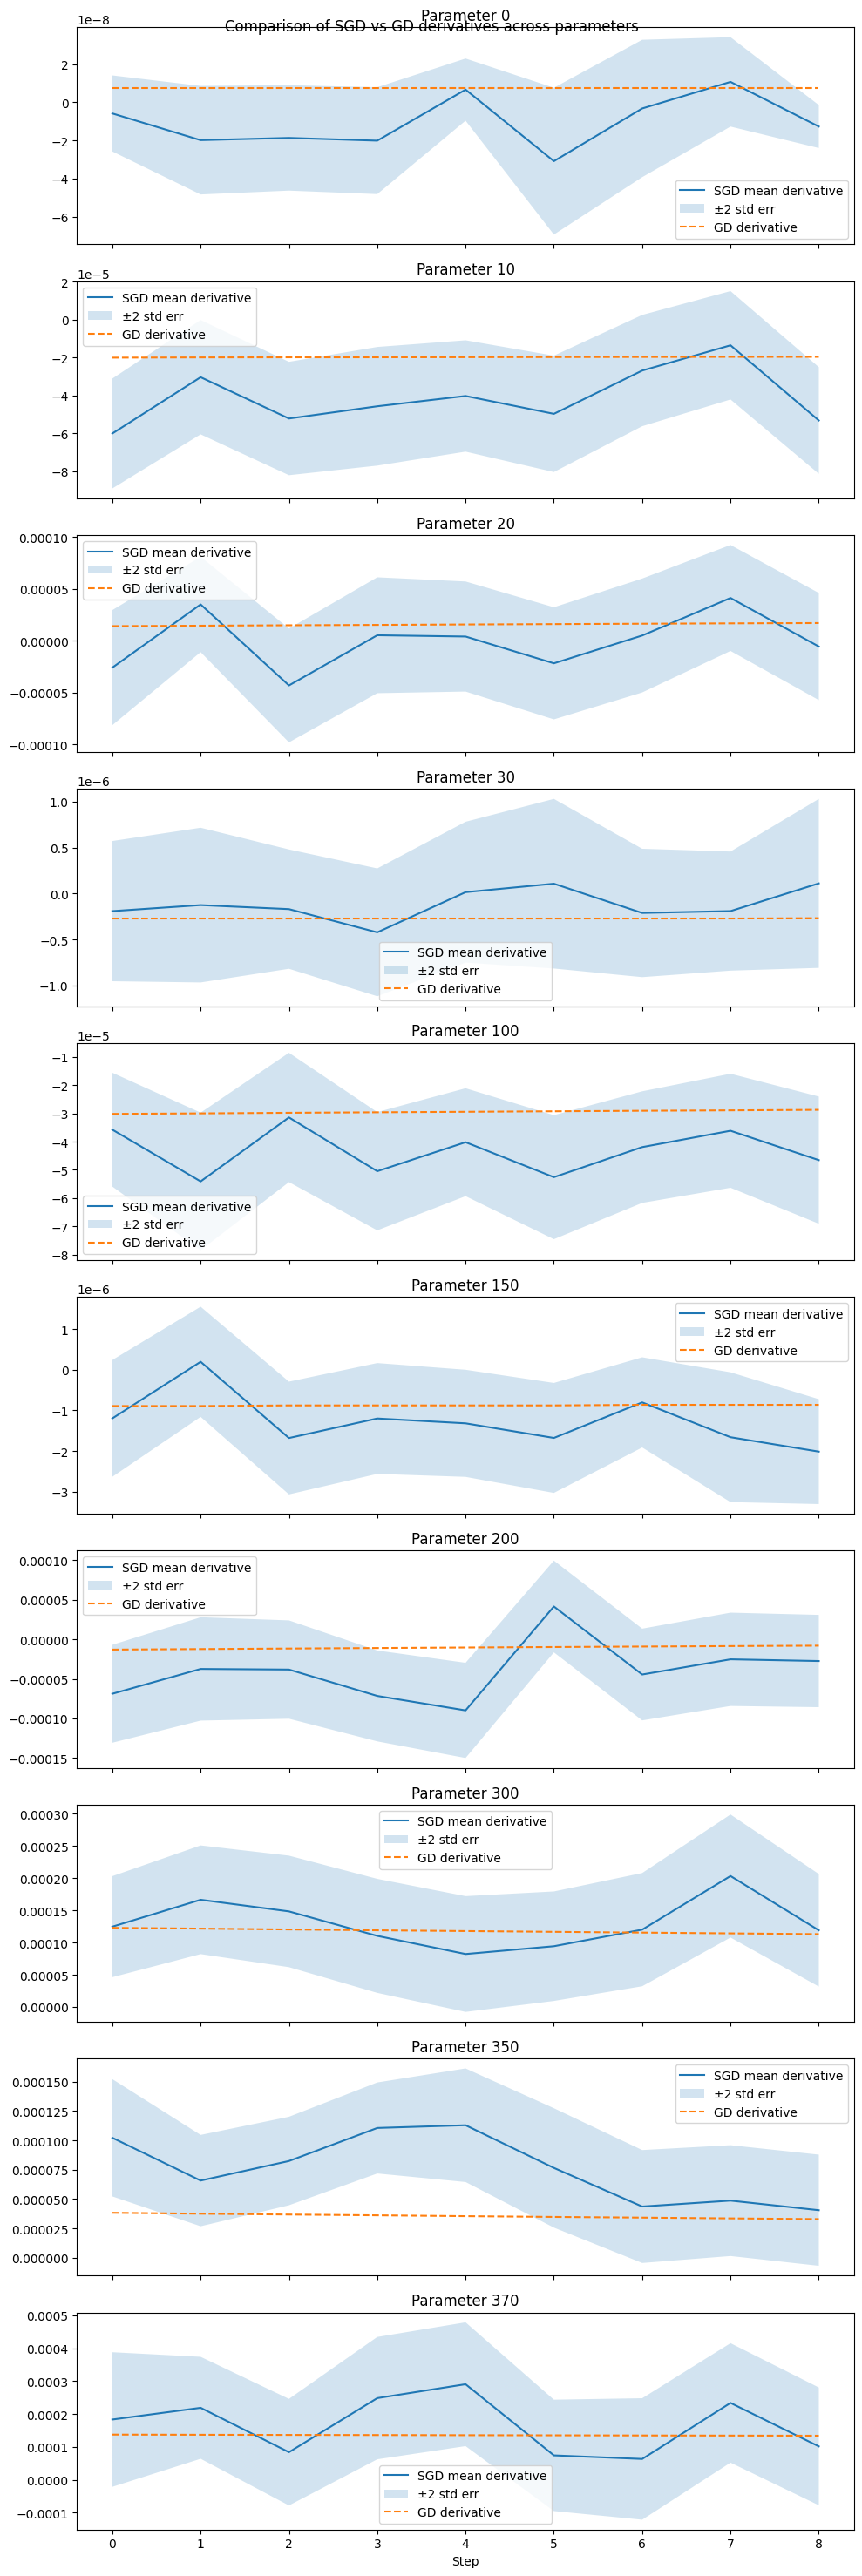

In [41]:
import numpy as np
import matplotlib.pyplot as plt

num_p_arr = [0, 10, 20, 30, 100, 150, 200, 300, 350, 370]

# Сколько шагов смотреть
max_steps = 10

fig, axes = plt.subplots(len(num_p_arr), 1, figsize=(10, 3 * len(num_p_arr)), sharex=True)

for idx, num_p in enumerate(num_p_arr):
    # --- Достаём траектории ---
    p_trajectories_sgd = W_SGD[:, :, num_p].numpy()  # [n_samples, n_steps]
    p_trajectories_gd = W_GD[ :, num_p].numpy()    # [1, n_steps]

    # --- Разности (производные по шагам) ---
    sgd_diff = p_trajectories_sgd[:, 1:max_steps] - p_trajectories_sgd[:, :max_steps-1]  # [n_samples, max_steps-1]
    gd_diff = p_trajectories_gd[1:max_steps] - p_trajectories_gd[:max_steps-1]     # [max_steps-1]

    # --- Усреднение и доверительный интервал ---
    sgd_mean = sgd_diff.mean(axis=0)
    sgd_std = sgd_diff.std(axis=0) / np.sqrt(sgd_diff.shape[0])  # ошибка среднего

    # --- Рисуем ---
    ax = axes[idx]
    ax.plot(sgd_mean, label="SGD mean derivative")
    ax.fill_between(np.arange(len(sgd_mean)), 
                    sgd_mean - 2*sgd_std, 
                    sgd_mean + 2*sgd_std, 
                    alpha=0.2, label="±2 std err")
    ax.plot(gd_diff, label="GD derivative", linestyle="--")
    ax.set_title(f"Parameter {num_p}")
    ax.legend()

plt.xlabel("Step")
plt.suptitle("Comparison of SGD vs GD derivatives across parameters")
plt.tight_layout()
plt.show()


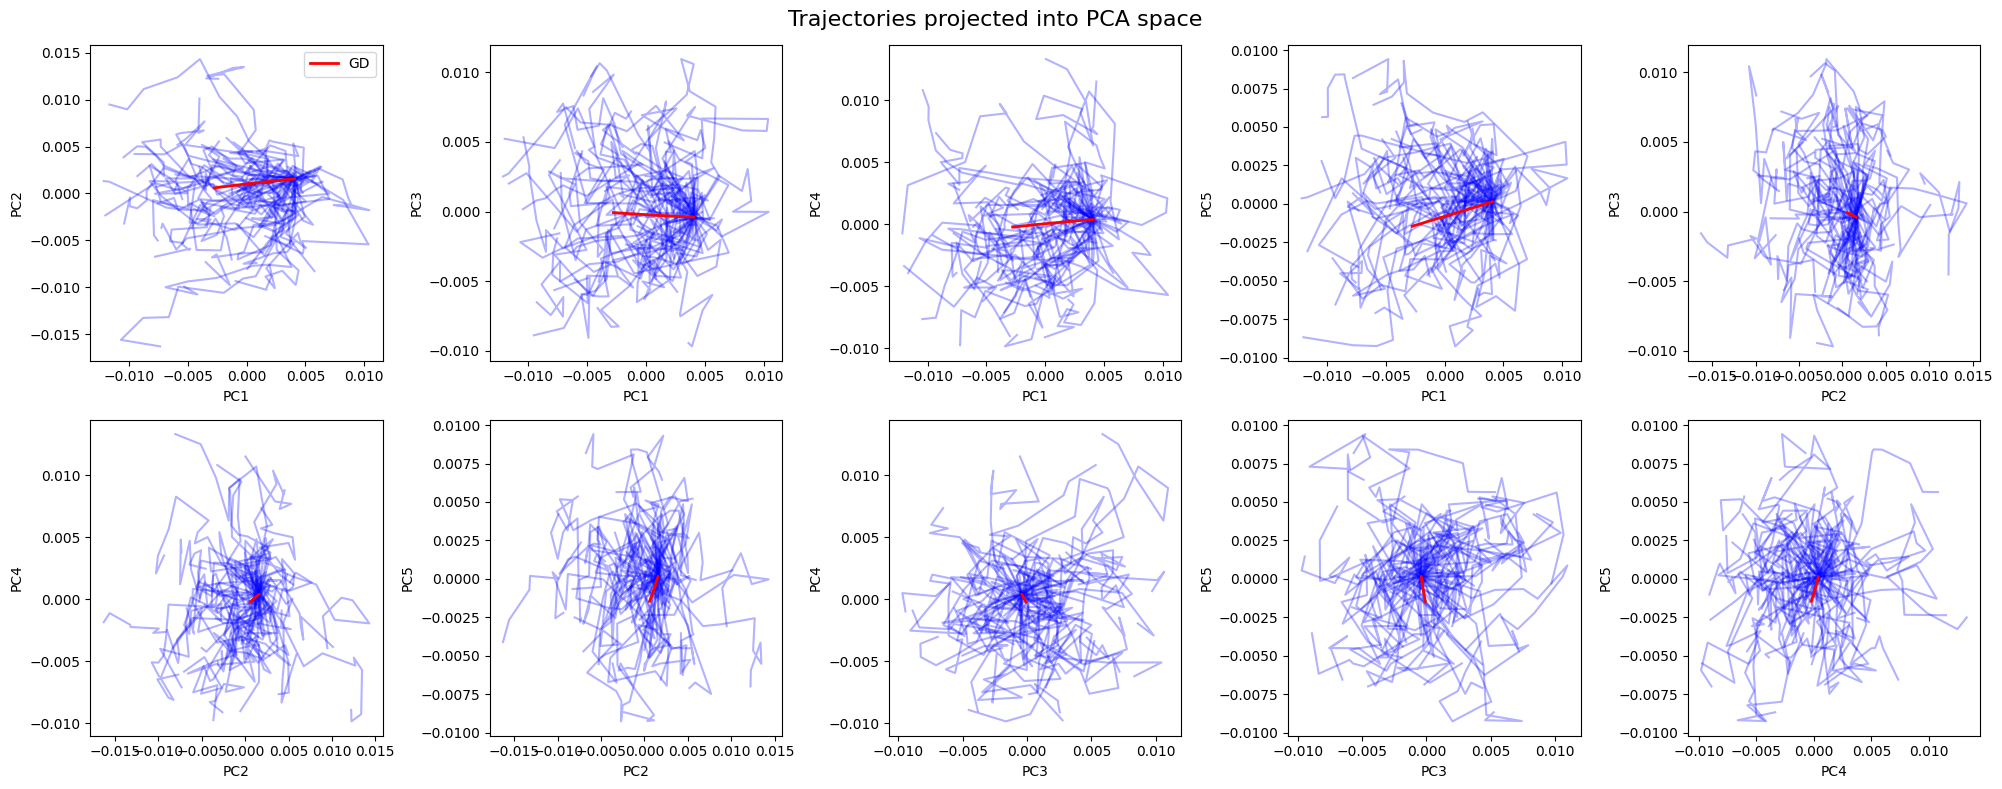

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# допустим W_SGD: [n_trials, T, d]
# допустим W_GD:  [1, T, d]

pairs = [(0,1), (0,2), (0,3), (0,4),
         (1,2), (1,3), (1,4),
         (2,3), (2,4),
         (3,4)]

# Берём все траектории SGD
n_trials, T, d = W_SGD.shape

# Для PCA склеиваем все траектории по времени и по траекториям
X = W_SGD.reshape(-1, d)  # [n_trials*T, d]

# Центрируем и делаем PCA
pca = PCA(n_components=5)
X_proj = pca.fit_transform(X)   # [n_trials*T, 5]

# Возвращаем в форму [n_trials, T, 5]
X_proj = X_proj.reshape(n_trials, T, -1)

# Теперь проекция GD
gd_proj = pca.transform(W_GD)   # [T, 5]

# --- Визуализация ---
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]
    # SGD trajectories
    for trial in range(min(50, n_trials)):   # рисуем не все, чтобы не захламлять
        ax.plot(X_proj[trial, :, i], X_proj[trial, :, j], alpha=0.3, color="blue")
    # GD trajectory
    ax.plot(gd_proj[:, i], gd_proj[:, j], color="red", linewidth=2, label="GD" if idx == 0 else "")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    if idx == 0:
        ax.legend()

fig.suptitle("Trajectories projected into PCA space", fontsize=16)
plt.tight_layout()
plt.show()
